In [ ]:
Data was collected to amount to a total of 100 unique gestures per twin, with 2 trials per gesture being used. 
Preprocessing:
    -Data was resampled to the median length of collected data
    -Data was cascaded into two dfs, each (200, 2124) in shape
    -Data was normalized
    -Data was split 70/30 for training and testing purposes
Analysis:
    -A PCA process was run on each training df (2 processes total)
    -Resulting eigenvector/value calculations resulted in a cumulative variance of 12
    -Testing data was reconstructed based on the captured synergies via pseudo inverse function
    -Reconstructions were compared to the original using sum of squared difference(SSD) resulting in:
        -Abhay: SSD: 16847.2693, MSE (mean squared error): 0.132198
        -Arjun: SSD: 16287.7298, MSE (mean squared error): 0.127807

In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# === Config ===
expected_columns = [
    'time', 'palm_position_x', 'palm_position_y', 'palm_position_z',
    'palm_normal_x', 'palm_normal_y', 'palm_normal_z',
    'palm_direction_x', 'palm_direction_y', 'palm_direction_z',
    'hand_grab_angle', 'hand_grab_strength', 'hand_pinch_angle', 'hand_pinch_strength',
    'thumb_extension', 'index_extension', 'middle_extension', 'ring_extension', 'pinky_extension'
]
input_folder = r"C:\Users\Abhay\Downloads\ExportedSheets"

# === Utility Functions ===
def is_row_empty(row):
    return all(pd.isna(cell) or (isinstance(cell, str) and cell.strip() == '') for cell in row)

def trim_leading_empty_rows(df):
    for i in range(len(df)):
        if not is_row_empty(df.iloc[i]):
            return df.iloc[i:].reset_index(drop=True)
    return pd.DataFrame(columns=df.columns)

def trim_trailing_empty_rows(df):
    for i in reversed(range(len(df))):
        if not is_row_empty(df.iloc[i]):
            return df.iloc[:i+1].reset_index(drop=True)
    return pd.DataFrame(columns=df.columns)

def find_trial_split_index(df):
    for i in range(len(df)):
        if is_row_empty(df.iloc[i]):
            return i
    return None

def split_trials(df):
    df = trim_leading_empty_rows(df)
    split_idx = find_trial_split_index(df)
    if split_idx is None:
        return df.reset_index(drop=True), pd.DataFrame(columns=df.columns)
    trial1 = df.iloc[:split_idx]
    trial2 = df.iloc[split_idx+1:]
    trial1 = trim_trailing_empty_rows(trial1)
    trial2 = trim_leading_empty_rows(trial2)
    trial2 = trim_trailing_empty_rows(trial2)
    return trial1.reset_index(drop=True), trial2.reset_index(drop=True)

def resample_by_time(df, time_col, target_rows):
    df = df.copy()
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col])
    df = df.drop_duplicates(subset=time_col)
    for col in df.columns:
        if col != time_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.set_index(time_col)
    new_time_index = np.linspace(df.index.min(), df.index.max(), target_rows)
    df_resampled = df.reindex(new_time_index)
    df_resampled = df_resampled.interpolate(method='linear', axis=0).reset_index()
    df_resampled.rename(columns={'index': time_col}, inplace=True)
    return df_resampled

def safe_resample(df_list, time_col, target_rows):
    return [
        resample_by_time(df, time_col, target_rows)
        for df in df_list
        if time_col in df.columns and not df.empty
    ]

def cascade_single_trial(df):
    df = df[[col for col in df.columns if not col.endswith("time")]]
    return pd.DataFrame([df.to_numpy().T.flatten()])

def get_k_components(pca, threshold=0.90):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    k = np.argmax(cumulative_variance >= threshold) + 1
    return k

def reconstruct_from_pca(test_df, pca, k_components):
    eigenvectors_k = pca.components_[:k_components, :]
    projected = np.dot(test_df, eigenvectors_k.T)
    reconstructed = np.dot(projected, eigenvectors_k)
    return pd.DataFrame(reconstructed)

def compute_errors(original, reconstructed):
    original_np = original.to_numpy()
    reconstructed_np = reconstructed.to_numpy()
    ssd = np.sum((original_np - reconstructed_np) ** 2)
    mse = mean_squared_error(original_np, reconstructed_np)
    return ssd, mse


# === Load and Process All Files ===
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
abhay_trials, arjun_trials = [], []

for file in csv_files:
    path = os.path.join(input_folder, file)
    try:
        df = pd.read_csv(path, header=None)
        df = df.iloc[1:].reset_index(drop=True)
        df = df.iloc[:, :39]

        abhay_df = df.iloc[:, :19].copy()
        arjun_df = df.iloc[:, 20:].copy()

        abhay_df.columns = [f"Abhay_{col}" for col in expected_columns]
        arjun_df.columns = [f"Arjun_{col}" for col in expected_columns]

        abhay_df.dropna(axis=1, how='all', inplace=True)
        arjun_df.dropna(axis=1, how='all', inplace=True)

        abhay_t1, abhay_t2 = split_trials(abhay_df)
        arjun_t1, arjun_t2 = split_trials(arjun_df)

        abhay_trials.extend([abhay_t1, abhay_t2])
        arjun_trials.extend([arjun_t1, arjun_t2])
    except Exception as e:
        print(f"Error processing {file}: {e}")

# === Resample all trials ===
all_lengths = [len(df) for df in abhay_trials + arjun_trials]
median_len = int(np.median(all_lengths))
print(f"Using median trial length: {median_len}")

abhay_trials = safe_resample(abhay_trials, 'Abhay_time', median_len)
arjun_trials = safe_resample(arjun_trials, 'Arjun_time', median_len)

# === Cascade Each Trial Individually ===
cascaded_abhay = pd.concat([cascade_single_trial(trial) for trial in abhay_trials], ignore_index=True)
cascaded_arjun = pd.concat([cascade_single_trial(trial) for trial in arjun_trials], ignore_index=True)
print(f"Cascaded Abhay: {cascaded_abhay.shape}, Arjun: {cascaded_arjun.shape}")

# === Normalize ===
scaler_abhay = MinMaxScaler()
normalized_abhay = pd.DataFrame(scaler_abhay.fit_transform(cascaded_abhay))

scaler_arjun = MinMaxScaler()
normalized_arjun = pd.DataFrame(scaler_arjun.fit_transform(cascaded_arjun))

# === Train/Test Split (70/30 per person) ===
train_abhay = normalized_abhay.iloc[:140].reset_index(drop=True)
test_abhay = normalized_abhay.iloc[140:].reset_index(drop=True)

train_arjun = normalized_arjun.iloc[:140].reset_index(drop=True)
test_arjun = normalized_arjun.iloc[140:].reset_index(drop=True)

# === PCA Training ===
pca_abhay = PCA().fit(train_abhay)
pca_arjun = PCA().fit(train_arjun)

# === Determine top-k for 90% variance ===
k_abhay = get_k_components(pca_abhay, threshold=0.90)
k_arjun = get_k_components(pca_arjun, threshold=0.90)
print(f"Abhay PCA components (90% var): {k_abhay}")
print(f"Arjun PCA components (90% var): {k_arjun}")

# === Reconstruct test data ===
reconstructed_abhay = reconstruct_from_pca(test_abhay, pca_abhay, k_abhay)
reconstructed_arjun = reconstruct_from_pca(test_arjun, pca_arjun, k_arjun)

# === Compute Errors ===
ssd_abhay, mse_abhay = compute_errors(test_abhay, reconstructed_abhay)
ssd_arjun, mse_arjun = compute_errors(test_arjun, reconstructed_arjun)

# === Print Final Output ===
print("\n✅ PCA & Reconstruction Complete")
print(f"Abhay: Test {test_abhay.shape} -> Reconstructed {reconstructed_abhay.shape}")
print(f"Arjun: Test {test_arjun.shape} -> Reconstructed {reconstructed_arjun.shape}")
print(f"\n📊 Abhay SSD: {ssd_abhay:.4f}, MSE: {mse_abhay:.6f}")
print(f"📊 Arjun SSD: {ssd_arjun:.4f}, MSE: {mse_arjun:.6f}")


Using median trial length: 118
Cascaded Abhay: (200, 2124), Arjun: (200, 2124)
Abhay PCA components (90% var): 12
Arjun PCA components (90% var): 12

✅ PCA & Reconstruction Complete
Abhay: Test (60, 2124) -> Reconstructed (60, 2124)
Arjun: Test (60, 2124) -> Reconstructed (60, 2124)

📊 Abhay SSD: 16847.2693, MSE: 0.132198
📊 Arjun SSD: 16287.7298, MSE: 0.127807


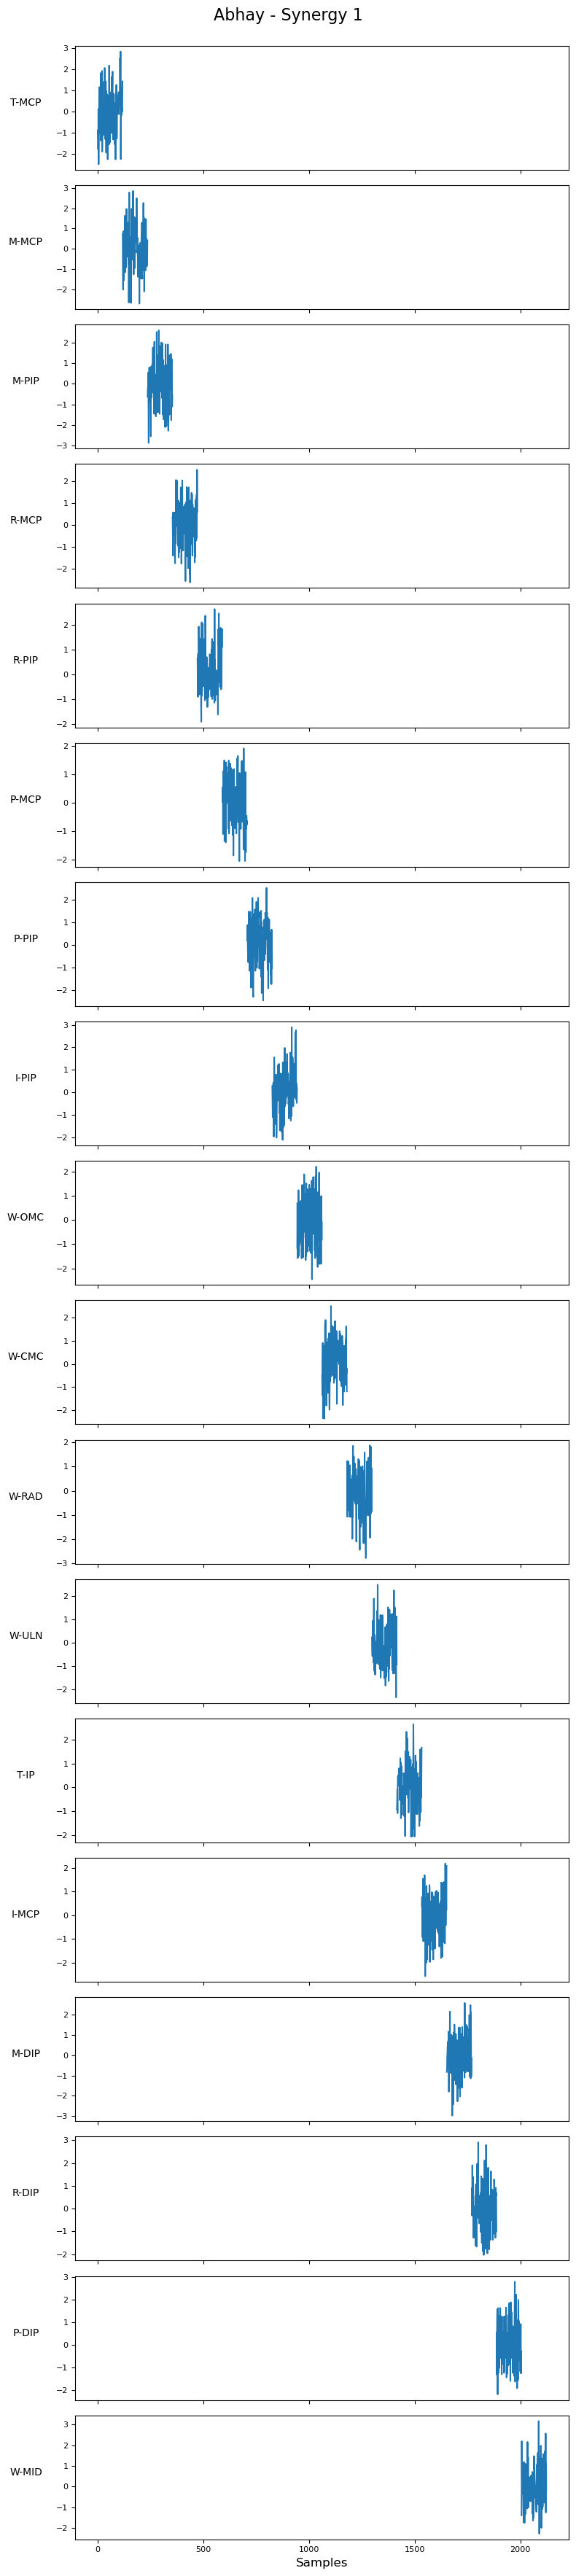

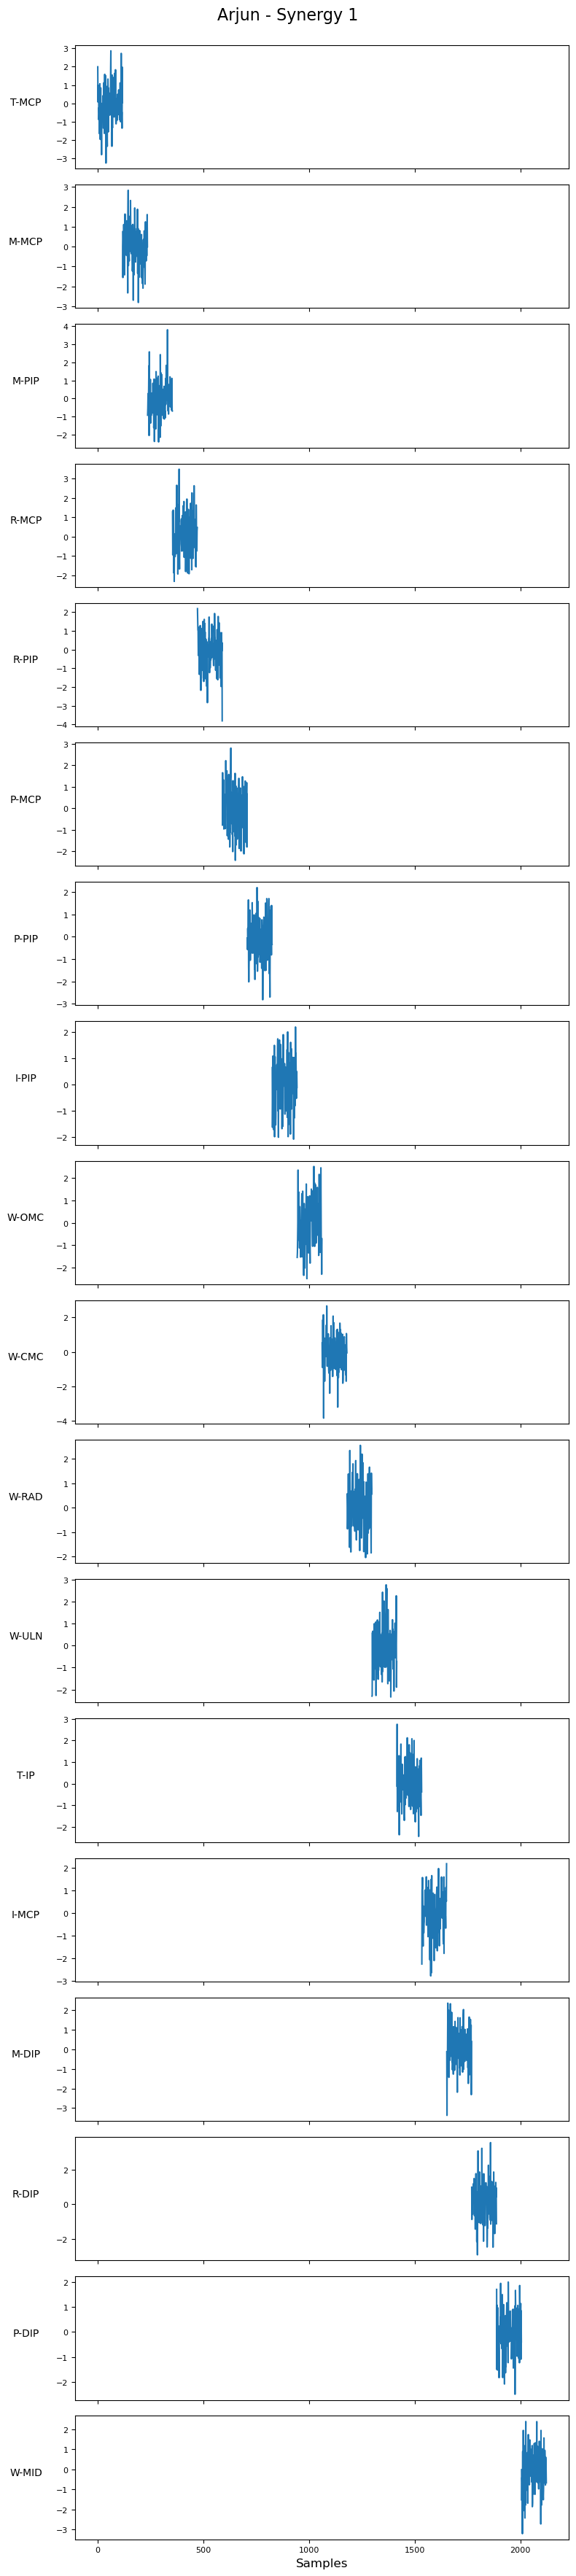

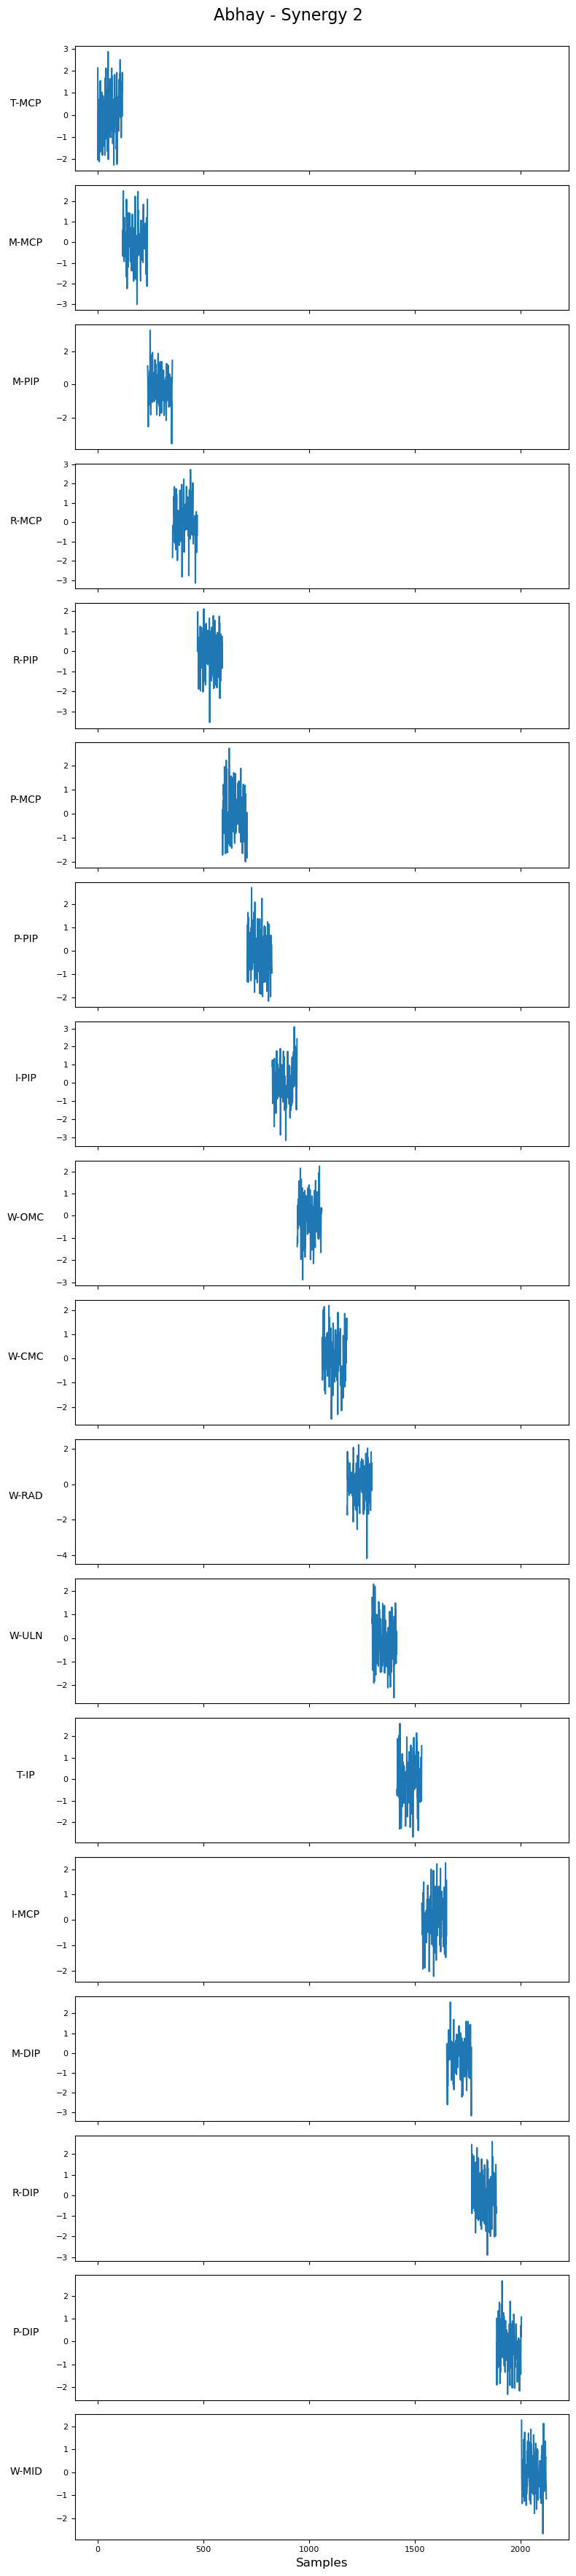

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
resample_length = 118
num_joints = 18
joint_labels = [
    "T-MCP", "M-MCP", "M-PIP", "R-MCP", "R-PIP", "P-MCP",
    "P-PIP", "I-PIP", "W-OMC", "W-CMC", "W-RAD", "W-ULN",
    "T-IP", "I-MCP", "M-DIP", "R-DIP", "P-DIP", "W-MID"
]
synergies_to_plot = [0, 1, 2, 8, 9, 10, 11]  # Synergies 1-3 and 9-12

# === Plotting Function ===
def plot_synergy_matrix(synergy_idx, eigenvectors, title_prefix=""):
    fig, axes = plt.subplots(nrows=num_joints, ncols=1, figsize=(8, 2 * num_joints), sharex=True)
    fig.suptitle(f"{title_prefix}Synergy {synergy_idx + 1}", fontsize=16)

    for j in range(num_joints):
        start = j * resample_length
        end = (j + 1) * resample_length
        axes[j].plot(eigenvectors.iloc[synergy_idx, start:end], linewidth=1.5)
        axes[j].set_ylabel(joint_labels[j], rotation=0, labelpad=30, fontsize=10)
        axes[j].tick_params(axis='y', labelsize=8)
        axes[j].tick_params(axis='x', labelsize=8)

    axes[-1].set_xlabel("Samples", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# === Plot all selected synergies ===
for idx in synergies_to_plot:
    plot_synergy_matrix(idx, eigenvectors_abhay, title_prefix="Abhay - ")
    plot_synergy_matrix(idx, eigenvectors_arjun, title_prefix="Arjun - ")
